In [2]:
import torch
import numpy as np
import pandas as pd
import os
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torcheval import metrics


import pickle
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


from model_definitions import *
from helper_class_definition import *

In [15]:
ds = MNIST(root = "data", download=False)

In [3]:
n=-1

tensor(5)


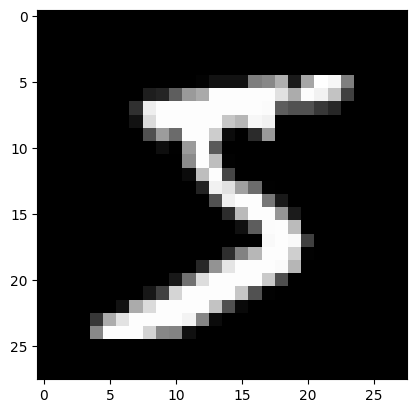

In [4]:
n+=1
print(ds.targets[n])
plt.imshow(ds.data[n].to(torch.float), cmap="grey")
plt.show()

In [16]:
shaped_data = ds.data.reshape([60000,28,28])
shaped_data = shaped_data.to(torch.float)
shaped_data.shape

torch.Size([60000, 28, 28])

In [ ]:
y = {"train":None, "test":None, "valid":None}
x = {"train":None, "test":None, "valid":None}

x["train"], x["test"], y["train"], y["test"] = train_test_split(shaped_data, ds.targets, train_size=0.8)
x["test"], x["valid"], y["test"], y["valid"] = train_test_split(x["test"], y["test"], train_size=0.75)

x["train"] = x["train"][:20000]
y["train"] = y["train"][:20000]

In [ ]:
total_dataset = {"x":x, "y":y}

with open("C://Austin//U_Cinci//Sem3//DeepLearning//Austin_Paulraj_Homework2//Implementation_Files//processed_dataset.pickle", 'wb') as handle:
    pickle.dump(total_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('C://Austin//U_Cinci//Sem3//DeepLearning//Austin_Paulraj_Homework2//Implementation_Files//processed_dataset.pickle', 'rb') as handle:
    total_dataset = pickle.load(handle)

In [ ]:
total_dataset = {"x":x["train"], "y":y["train"]}
valid_dataset = {"x":x["valid"], "y":y["valid"]}

for key in total_dataset.keys():
  if key == "x":
      total_dataset[key] = F.interpolate(total_dataset[key].unsqueeze(0), size=(224))
      valid_dataset[key] = F.interpolate(valid_dataset[key].unsqueeze(0), size=(224))

TypeError: new(): invalid data type 'str'

In [13]:
#Prepping DS for Resnet, VGG
for key in total_dataset.keys():
    if key == "x":
        total_dataset[key] = total_dataset[key].reshape(total_dataset["x"].shape[0],1,224,224)
        #valid_dataset[key] = valid_dataset[key].reshape(valid_dataset[key].shape[1],1,224,224)

In [4]:
for key in total_dataset.keys():
    print("train: ", total_dataset[key].shape)
    print("valid: ", valid_dataset[key].shape)

AttributeError: 'dict' object has no attribute 'shape'

In [49]:
#total_dataset = {"x":x["train"], "y":y["train"]}

with open("C://Austin//U_Cinci//Sem3//DeepLearning//Austin_Paulraj_Homework2//Implementation_Files//transformed_train_dataset.pickle", 'wb') as handle:
    pickle.dump(total_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open("C://Austin//U_Cinci//Sem3//DeepLearning//Austin_Paulraj_Homework2//Implementation_Files//transformed_valid_dataset.pickle", 'wb') as handle:
    pickle.dump(valid_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
from model_definitions import *
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import numpy as np
from torcheval.metrics import R2Score

class DL_Homework2_helper_class():
    """
    This class is a all in one Trainer class made to efficiently train all the different architectures described at one.
    It stors the dataset and has multiple dicts to concurently track the scores, weight updates and individual best models
    These dicts are saved in specific folders to be used in the final evaluation of the models

    The main functions implemented are:
        - validation_hyperparam_test: Uses the validation dataset to quickly test a matrix of hyper parameter combinations
        -- The output dictionary of this function Contains the validation R2 scores of every combination tested, and is used to find the
        -- hyperparameters that result in each architecture's best model

        - train_all_model_types: Trains all the models at once, used for both validation and the actual training steps
        -- Saves the best model by comparing R2 at each epoch
        -- The "Out_Dict" stores model information and epoch level scores to be saved and analyzed

        -nn_model_train_step: A helper function used to perform the backpropogation step as designed in pytorch
    """
    def __init__(self, x, y, device="cpu"):
        self.x = x
        self.y = y
        self.device= device
        self.out_dict = None
        self.optimizers = None
        self.validation_dict = None
        self.best = None

    def validation_hyperparam_test(self, loss_functions = [nn.MSELoss], optimizers = [torch.optim.SGD], lr_range = [0.0001, 0.001, 0.01, 0.1], epochs = 100, batch_size=200):
        
        # main tracking output of the validation step
        self.validation_dict = {}
        self.out_dict = None

        for loss_function in loss_functions:
            for optimizer in optimizers:
                for lr in lr_range:

                    # Loop through all combinations of hyper parameters
                    self.train_all_model_types(loss_func=loss_function, optimizer=optimizer, lr=lr, epochs=epochs, batch_size=batch_size, validation=True)
                    self.validation_dict[loss_function._get_name()+"_"+optimizer.__name__+"_"+str(lr)] = self.out_dict["Scores"]

                    #reset state dict for next training interation
                    self.out_dict = None


    def train_all_model_types(self, save_path="",  loss_func=nn.CrossEntropyLoss(), optimizer = torch.optim.Adam, lr=1e-1, epochs=10, train_lr=True, batch_size = 373, validation = False):
        # Define out dictionary if it has not been defined before
        ## If it has been defined before then it will skip this step and continue training on the same models 
        if self.out_dict == None:
            self.out_dict = {}

            # Set up scores dict to track and save Loss/R2 for future analysis
            self.out_dict["Scores"] = {}

            # Here we set up all the models defined in the "model_definitions" module for the different architectures to be tested
            self.out_dict["DNNNet"] = DNNNet().to(self.device)
            self.out_dict["ConvNet"] = ConvNet().to(self.device) 
            
            self.best = {}

            for key in self.out_dict.keys(): 
                # Here we define what is needed to  be track in the "Scores" dict
                ## If validation, then we only need the R2 Validation score
                ## Else we need R2 and Loss scores on both the Training and Testing models
                ### These are used for forming the epoch graphs and tables for model analysis
                if validation == False:
                    if key != "Scores":
                        self.out_dict["Scores"][key] = {"train":[], "valid":[], "loss":{"train":[], "valid":[]}}
                        self.best[key] = [0, -1]
                else:
                    if key != "Scores":
                        self.out_dict["Scores"][key] = {"valid":[]}
            
            #Pytorch requires separatly defined optimizers based on the model parameters
            # Here we set up the model specific optimizers for the training loop
            self.optimizers = {
                            key : optimizer(self.out_dict[key].parameters(), lr=lr) 
                                for key in self.out_dict.keys() 
                                if key!="Scores"
                        }
        
        #TQDM is used to show the progress of the model training by tracking the number of epochs
        for epoch in tqdm(range(epochs)):
            #print("Epoch: " + str(epoch))
            # We take a sub batch of the total train dataset to speed up training iterations
            ## With a high enough number of epochs, using this method of batching seems to help model generatlisation when compared to using all of it 
            for i in range(int(self.x["train"].shape[0]/batch_size)-1):
                ind = np.array([k for k in range(self.x["train"].shape[0])])
                np.random.shuffle(ind)
                if (i+1)*batch_size <= self.x["train"].shape[0]:
                    x_batch = torch.Tensor(self.x["train"][i*batch_size : (i+1)*batch_size])
                    y_batch = torch.Tensor(self.y["train"][i*batch_size : (i+1)*batch_size])
                else:
                    x_batch = torch.Tensor(self.x["train"][i*batch_size : -1])
                    y_batch = torch.Tensor(self.y["train"][i*batch_size : -1])
                
                x_batch = x_batch.reshape([x_batch.shape[0], 1, 28 ,28])

                for key in self.out_dict.keys(): 
                    if key != "Scores":
                        if key == "DNNNet":
                            x_batch = x_batch.reshape([x_batch.shape[0], 784])

                        self.out_dict[key].train(True)
                        #Sequentially train each model architecture based on the current feature sampe and target y value
                        self.nn_model_train_step(self.out_dict[key], key, self.optimizers[key], x_batch, y_batch, loss_func=loss_func, lr=lr)
                        if key == "DNNNet":

                            x_batch = x_batch.reshape([x_batch.shape[0], 1, 28 ,28])
            
            out_str = ""
            for key in self.out_dict.keys(): 
                if key != "Scores":
                    self.out_dict[key].eval()
                    with torch.no_grad():
                    # After each training Epoch, we update the Scores dict with what is required as defined before
                        if validation == False:
                            
                            if key == "DNNNet":
                                train = self.out_dict[key](self.x["train"].reshape([self.x["train"].shape[0], 784]))
                                test = self.out_dict[key](self.x["valid"].reshape([self.x["valid"].shape[0], 784]))
                            
                            else:
                                train = self.out_dict[key](self.x["train"].reshape([self.x["train"].shape[0], 1, 28, 28]))
                                test = self.out_dict[key](self.x["valid"].reshape([self.x["valid"].shape[0], 1, 28 ,28]))

                            #train = train.reshape([train.shape[0]])
                            acc = loss_func(train, self.y["train"])
                            self.out_dict["Scores"][key]["train"].append(acc)

                            #Current epoch test set R2
                            
                            #test = test.reshape([test.shape[0]])
                            acc2 = loss_func(test, torch.Tensor(self.y["valid"]))

                            f1 = metrics.MulticlassF1Score()
                            f1.update(test, self.y["valid"])
                            f1_score = f1.compute()
                            self.out_dict["Scores"][key]["valid"].append(f1_score)

                            if self.best[key][1] < self.out_dict["Scores"][key]["valid"][-1]:
                                self.best[key][1] = self.out_dict["Scores"][key]["valid"][-1]
                                self.best[key][0] = epoch
                                torch.save(self.out_dict[key], save_path+"//"+key+".pickle")
                            
                            #print(str(key)+": "+str(self.out_dict["Scores"][key]["train"][-1])+ " | val_f1: "+str(self.out_dict["Scores"][key]["valid"][-1]))
                        
                        else:
                            
                            if key == "DNNNet":
                                train = self.out_dict[key](self.x["valid"].reshape([self.x["valid"].shape[0], 784]))
                            
                            else:
                                train = self.out_dict[key](self.x["valid"].reshape([self.x["valid"].shape[0], 1, 28, 28]))

                            #Current epoch validation set R2
                            acc = loss_func(train, self.y["valid"])
                            self.out_dict["Scores"][key]["valid"].append(acc)
                        
                    

    def nn_model_train_step(self, model, key, optimizer, x, y, loss_func=nn.CrossEntropyLoss(), lr=1e-1):
        optimizer.zero_grad()
        #Training loop step as defined for Pytorch models
        pred = model.forward(x)
        output = loss_func(pred, y)
        #print(output)
        output.backward()
        optimizer.step()
        



In [18]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 2, 2),
            nn.ReLU(),
            nn.MaxPool2d(2,2,1),
            nn.Conv2d(8, 16, 2, 2, 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(6*6*16,288),
            nn.ReLU(),
            nn.Linear(288,10),
        )
    
    def forward(self, x):
        return self.conv_layers(x)
    
class DNNNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196,10),
        )
    
    def forward(self, x):
        return self.conv_layers(x)
    



In [7]:
x = total_dataset["x"]
y = total_dataset["y"]

In [15]:
x["train"][0].shape

torch.Size([28, 28])

In [19]:
trainer = DL_Homework2_helper_class(x,y,"cpu")

In [22]:
trainer.validation_hyperparam_test(loss_functions=[nn.CrossEntropyLoss()], optimizers=[torch.optim.Adadelta, torch.optim.Adagrad, torch.optim.Adam, torch.optim.SGD], lr_range=[0.1, 0.05, 0.0001, 0.001, 0.005, 0.01], epochs=50)

100%|██████████| 50/50 [01:24<00:00,  1.68s/it]


In [25]:
with open("C://Austin//U_Cinci//Sem3//DeepLearning//Austin_Paulraj_Homework2//Implementation_Files//validation_loss_dict.pickle", 'wb') as handle:
    pickle.dump(trainer.validation_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
trainer.validation_dict.keys()

dict_keys(['CrossEntropyLoss_Adadelta_0.1', 'CrossEntropyLoss_Adadelta_0.05', 'CrossEntropyLoss_Adadelta_0.0001', 'CrossEntropyLoss_Adadelta_0.001', 'CrossEntropyLoss_Adadelta_0.005', 'CrossEntropyLoss_Adadelta_0.01', 'CrossEntropyLoss_Adagrad_0.1', 'CrossEntropyLoss_Adagrad_0.05', 'CrossEntropyLoss_Adagrad_0.0001', 'CrossEntropyLoss_Adagrad_0.001', 'CrossEntropyLoss_Adagrad_0.005', 'CrossEntropyLoss_Adagrad_0.01', 'CrossEntropyLoss_Adam_0.1', 'CrossEntropyLoss_Adam_0.05', 'CrossEntropyLoss_Adam_0.0001', 'CrossEntropyLoss_Adam_0.001', 'CrossEntropyLoss_Adam_0.005', 'CrossEntropyLoss_Adam_0.01', 'CrossEntropyLoss_SGD_0.1', 'CrossEntropyLoss_SGD_0.05', 'CrossEntropyLoss_SGD_0.0001', 'CrossEntropyLoss_SGD_0.001', 'CrossEntropyLoss_SGD_0.005', 'CrossEntropyLoss_SGD_0.01'])

In [23]:
#Display best hyperparameters 
best = {"DNNNet":[0,np.Inf,""], "ConvNet":[0,np.Inf,""]}

for key in trainer.validation_dict.keys():
    for model in trainer.validation_dict[key]:
        max_ind = torch.Tensor(trainer.validation_dict[key][model]["valid"]).argmin()
        if float(np.round(float(trainer.validation_dict[key][model]["valid"][max_ind]), 3)) < best[model][1]:
            best[model][0] = int(max_ind)
            best[model][1] = float(np.round(float(trainer.validation_dict[key][model]["valid"][max_ind]), 3))
            best[model][2] = key

best

{'DNNNet': [11, 0.13, 'CrossEntropyLoss_Adadelta_0.1'],
 'ConvNet': [36, 0.134, 'CrossEntropyLoss_Adam_0.0001']}

In [29]:
trainer = DL_Homework2_helper_class(x,y,"cpu")
trainer.train_all_model_types("C://Austin//U_Cinci//Sem3//DeepLearning//Austin_Paulraj_Homework2//Implementation_Files//saved_models//run1", epochs=50, batch_size=200, lr=0.1, optimizer=torch.optim.Adadelta)

100%|██████████| 50/50 [01:59<00:00,  2.40s/it]


In [30]:
for key in trainer.best.keys():
    print(key+": "+str(trainer.best[key]))

DNNNet: [23, tensor(0.9703)]
ConvNet: [45, tensor(0.9587)]


In [31]:
trainer2 = DL_Homework2_helper_class(x,y,"cpu")
trainer2.train_all_model_types("C://Austin//U_Cinci//Sem3//DeepLearning//Austin_Paulraj_Homework2//Implementation_Files//saved_models//run2", epochs=50, batch_size=200, lr=0.0001, optimizer=torch.optim.Adam)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:59<00:00,  2.39s/it]


In [32]:
for key in trainer2.best.keys():
    print(key+": "+str(trainer2.best[key]))

DNNNet: [49, tensor(0.9623)]
ConvNet: [47, tensor(0.9613)]
